#part 2

imports and create the relevant dirs

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
import os
import random
from skimage.io import imread
from PIL import Image
import glob

# pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

# define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
os.makedirs('./my_data', exist_ok=True)
os.makedirs('./my_data/part2', exist_ok=True)
os.makedirs('./my_data/part2/video', exist_ok=True)
#from frame_video_convert import *

paths for all files, can change for later

In [0]:
original_video_path = './my_data/part2/video/mk.mp4'
original_frames_path =  './output/frames/'
segmented_frames_path = './output/seg_frames/'
covid_video_path = './my_data/part2/video/Covid19.mp4'
covid_frames_path =  './output/covid_frames/'
segmented_covid_frames_path='./output/seg_covid_frames/'
output_frames_path='./output/scene_framess/'
output_video = './output/mk_fight_video.mp4'

In [0]:
def image_seq_to_video(imgs_path, output_path='./video.mp4', fps=15.0):
    output = output_path
    img_array = []
    for filename in sorted(glob.glob(os.path.join(imgs_path, '*.jpg'))):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        # img = cv2.resize(img, (width // 2, height // 2))
        img = cv2.resize(img, (width, height))
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)

    print(size)
    print("writing video...")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use lower case
    out = cv2.VideoWriter(output, fourcc, fps, size)
    # out = cv2.VideoWriter('project.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    print("saved video @ ", output)


def video_to_image_seq(vid_path, output_path='./datasets/OTB/img/Custom/'):
    os.makedirs(output_path, exist_ok=True)
    vidcap = cv2.VideoCapture(vid_path)
    success, image = vidcap.read()
    count = 0
    print("converting video to frames...")
    while success:
        fname = str(count).zfill(4)
        cv2.imwrite(os.path.join(output_path, fname + ".jpg"), image)  # save frame as JPEG file
        success, image = vidcap.read()
        count += 1
    print("total frames: ", count)

lets start with some functions that will help us along the way:


In [0]:
def display_im(images):
  """
  display images from the input list
  """
  fig, axes = plt.subplots(1,len(images),figsize=(15,10))
  for idx, image in enumerate(images):
    axes[idx].imshow(image)
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    axes[idx].axis('off')


def save_frames(frame_list,frame_path):
  """
  save frames from framelist into frame_path dir
  """
  os.makedirs(frame_path, exist_ok=True)
  count = 0
  for image in frame_list:
      fname = str(count).zfill(4)
      image = image[:, :, ::-1].copy() 
      cv2.imwrite(os.path.join(frame_path, fname + ".jpg"), image)  # save frame as JPEG file
      count += 1


def choose_random_im(images_path,num_to_display=2,to_display=False,rotate90=False):
  """
  chooses num_to_display images from images_path
  input:
    images_path: path for the dir with all images
    num_to_display: how many images to display
    to_display: True if you want the function to display
    rotate90: True if we want to rotate the image
  output:
    a list of the randomly picked images
  """
  random_im=[]
  for i in range(num_to_display):
    random_pick = random.choice([
      x for x in os.listdir(images_path)    
    ])
    image=cv2.imread(images_path+random_pick)
    if (rotate90):
      image=cv2.rotate(image,cv2.ROTATE_90_COUNTERCLOCKWISE)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    random_im.append(image)
  if (to_display):
    display_im(random_im)
  return random_im

#section 2.1

now we will convert a video into frames and display 2 random frames

converting video to frames...
total frames:  211


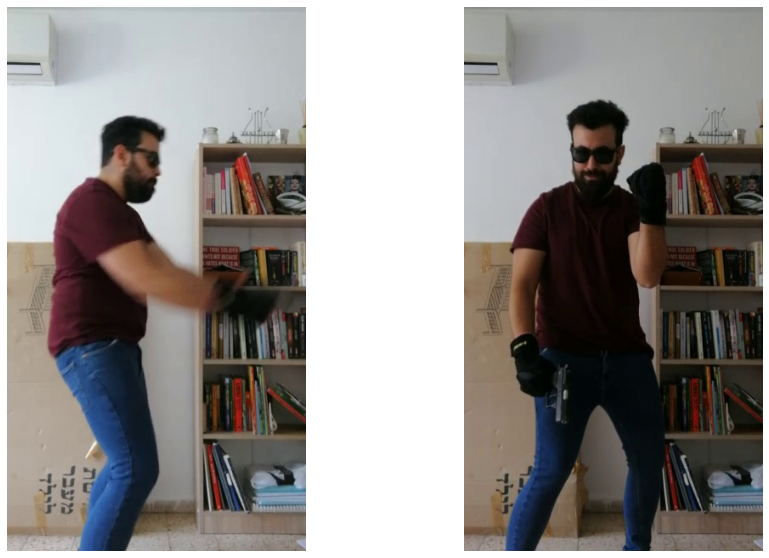

In [0]:
#create the frames
video_to_image_seq(original_video_path,original_frames_path)

#choose 2 random frames and display them
_ = choose_random_im(original_frames_path,2,to_display=True, rotate90=True)

# section 2.2

can use import from part 1
for your comfort, here is deeplab3 segmentation function

In [0]:
def deeplab3_segmentation(images_path):
  """
  this function preform semantic segmentation on all images in a given path
  preform with black background and colorpallet
  input
    images_path: path for the dir with all images
  output:
  segmented: a list of segmented images with black background
   segmented_colors: a list of segmented images with colors
  """
  
  model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
  
  #inference mode
  model.eval();

  # define the pre-processing steps  image->tensor, normalization
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  
  frames = [dI for dI in sorted(os.listdir(images_path))] #put all the paths in array
  segmented=[] #will contain the output
  segmented_colors = [] #output colorpalete
  for frame in frames:

    input_image = Image.open(images_path+ frame)
    input_image_array = imread(images_path+ frame)

    # perform pre-processing
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch of size 1 as expected by the model

    # send to device
    model = model.to(device)
    input_batch = input_batch.to(device)
    # forward pass
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)

    #create a mask to delete background
    masked_seg = np.array(output_predictions.byte().cpu().numpy(), dtype=np.bool)
    input_image_array[masked_seg == 0 ] = 0
    
    # create a color pallette, selecting a color for each class
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")
    # plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
    r.putpalette(colors)
     
    segmented_colors.append(r)
    segmented.append(input_image_array)
  return segmented, segmented_colors

let's use deeplab3 to segment the image from the frames and display randomly 2 frames both by original pic and by color segmentation

In [0]:
segmented_frames,colored_seg_frames = deeplab3_segmentation(original_frames_path)

Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


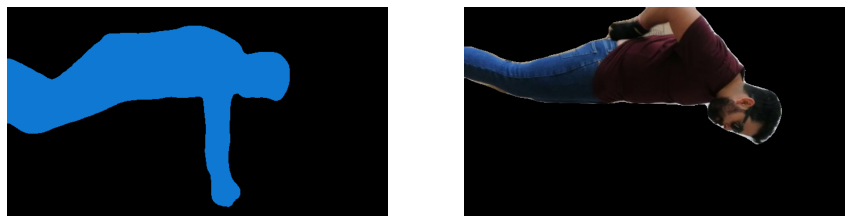

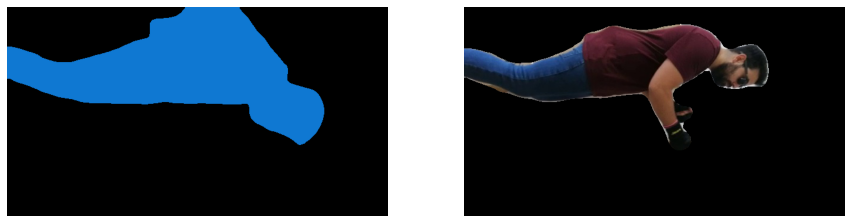

In [0]:

for i in range(2):
  random_pick = random.choice([ x for x in segmented_frames])
  random_pick_color = random.choice([ x for x in colored_seg_frames])
  #random_pick=cv2.rotate(random_pick,cv2.ROTATE_90_COUNTERCLOCKWISE)
  #random_pick_color=cv2.rotate(random_pick_color,cv2.ROTATE_90_COUNTERCLOCKWISE)
  display_im([random_pick_color,random_pick])


now we save the segmented images

In [0]:
save_frames(segmented_frames,segmented_frames_path)

#section 2.3


lets define and display 2 frames in the same way

converting video to frames...
total frames:  300


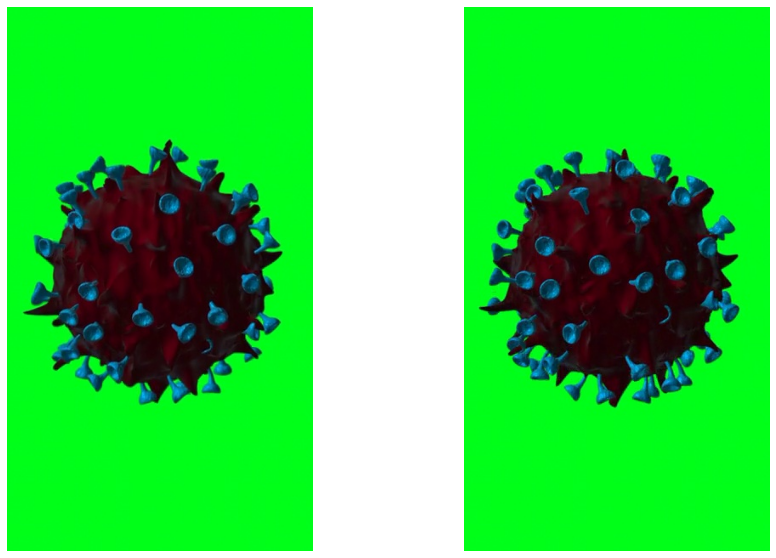

In [0]:
video_to_image_seq(covid_video_path,covid_frames_path)

_=choose_random_im(covid_frames_path,2,True,True)

since the instance is not classic object and the background is already diffrent
we simply used kmeans to cut the background by segmentation

In [0]:
from sklearn.cluster import KMeans
def kmeans_segment(images_path):

  frames = [dI for dI in sorted(os.listdir(images_path))]
  segmented=[]
  for frame in frames:
    pic = plt.imread(images_path+ frame)/255  # dividing by 255 to bring the pixel values between 0 and 1
    #resize to make it faster
    pic = resize_figure(pic,50)
    #reshape to a 3 dim stack
    pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])

    kmeans = KMeans(n_clusters=2, random_state=0).fit(pic_n)
    pic2show = kmeans.cluster_centers_[kmeans.labels_]

    cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
    pic[cluster_pic == cluster_pic[0]]=0

    #resize back
    pic = resize_figure(pic,200)

    segmented.append(pic)
  return segmented

and of course display and save them

In [0]:
segmented_covid_frames = kmeans_segment(covid_frames_path)

In [0]:
correctness_covid=[]
for i in segmented_covid_frames:
  correctness_covid.append(255*i)

save_frames(correctness_covid,segmented_covid_frames_path)

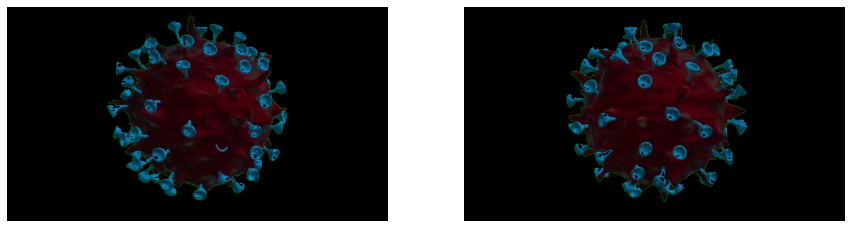

In [0]:
#print frames
ima=[]
for i in range(2):
  random_pick = random.choice([ x for x in segmented_covid_frames])
  ima.append(random_pick)
display_im(ima)

#section 2.4
stitch it all

first, lets see the original size of the images

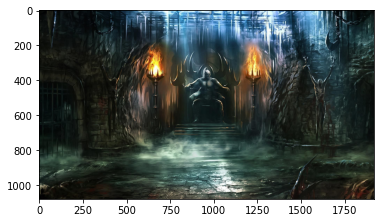

In [0]:
background = cv2.imread("./my_data/part2/liukang.jpg")
background = cv2.cvtColor(background,cv2.COLOR_BGR2RGB)
plt.imshow(background)

In [0]:
img1 = cv2.imread('./output/seg_frames/0000.jpg')
img2 = cv2.imread('./output/seg_covid_frames/0000.jpg')
img1 = cv2.cvtColor(cv2.rotate(img1,cv2.ROTATE_90_COUNTERCLOCKWISE),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.rotate(img2,cv2.ROTATE_90_COUNTERCLOCKWISE),cv2.COLOR_BGR2RGB)

print("my image size: {0}".format(img1.shape[:-1]))
print("corona size: {0}".format(img2.shape[:-1]))
print("background size: {0}".format(background.shape[:-1]))

my image size: (640, 352)
corona size: (640, 360)
background size: (1080, 1920)


we wanted a nice video, but segmentation on big images take time
so lets resize the segmented pictures

In [0]:
def resize_figure(image,scale_percent=60):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)
  # resize image
  resized_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  return resized_image

and of course, stitch the images together with the right offset

In [0]:
def put_forground_on_background(background, fore, x=0, y=0):
    back = background.copy()
    rows, cols, channels = fore.shape    
    trans_indices = fore[...,2] != 0 # Where not transparent
    overlay_copy = back[y:y+rows, x:x+cols] 
    overlay_copy[trans_indices] = fore[trans_indices]
    back[y:y+rows, x:x+cols] = overlay_copy
    return back

greatת now we can create it on all frames

In [0]:
#important note: currently working with 4 digits frame
def create_scene(background,frame_path,opp_frame_path,out_path = './output/scene_framess/'):
  frames = [dI for dI in sorted(os.listdir(frame_path))]
  opp_frame = [dI for dI in sorted(os.listdir(opp_frame_path))]
  scene=[]
  count=0
  for frame in frames:
    count+=1
    #print(frame_path + frame)
    img1 = cv2.imread(frame_path +'/'+ frame)

    img1 = cv2.rotate(img1,cv2.ROTATE_90_COUNTERCLOCKWISE)
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    bigger_me = resize_figure(img1,150)
    back = put_forground_on_background(background, bigger_me, 50, 100)
    img2 = cv2.imread(opp_frame_path + '/'+frame)
    img2 = cv2.cvtColor(cv2.rotate(img2,cv2.ROTATE_90_COUNTERCLOCKWISE),cv2.COLOR_BGR2RGB)
    big_covid= resize_figure(img2,150)
    if (count > 145 ):
      big_covid= resize_figure(big_covid,16500/(count*1.3))
      big_covid = cv2.cvtColor(big_covid,cv2.COLOR_RGB2HSV)
      big_covid[:,:,1] = big_covid[:,:,1] * count/145
      big_covid[:,:,0] = big_covid[:,:,0] * count/100
      big_covid[:,:,2] = big_covid[:,:,2] * 1.2
      big_covid = cv2.cvtColor(big_covid,cv2.COLOR_HSV2RGB)
      big_covid[:,:,0] = big_covid[:,:,0] * count/140
      back = put_forground_on_background(back, big_covid, 1100+count, count)
    else:
      back = put_forground_on_background(back, big_covid, 1200, 100)
    scene.append(back)
  save_frames(scene,out_path)
  return scene

In [0]:
scene = create_scene(background,segmented_frames_path,segmented_covid_frames_path,out_path= output_frames_path)

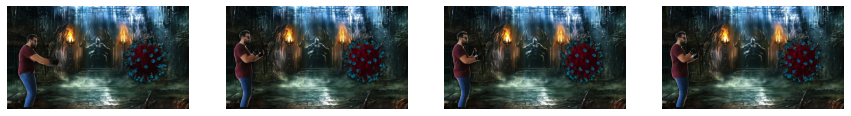

In [0]:
random_frames=[]
for i in range(3):
  random_pick = random.choice([ x for x in scene])
  random_frames.append(random_pick)
display_im(random_frames)

In [0]:
image_seq_to_video(output_frames_path, output_video,fps=30.0)

(1920, 1080)
writing video...
saved video @  ./output/mk_fight_video.mp4
